In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.var_model import VAR

file_path = Path("round-3-island-data-bottle")

In [3]:
if file_path.exists():
    # Read the CSV file
    df_day_0 = pd.read_csv(
        file_path / "prices_round_3_day_0.csv", delimiter=";"
    )  # day 0
    df_day_1 = pd.read_csv(
        file_path / "prices_round_3_day_1.csv", delimiter=";"
    )  # day 1
    df_day_2 = pd.read_csv(
        file_path / "prices_round_3_day_2.csv", delimiter=";"
    )  # day 2
    print("File loaded successfully.")
else:
    print("File not found. Please ensure the file exists at:", file_path)

df_day_0["timestamp"] = pd.to_numeric(df_day_0["timestamp"])
df_day_1["timestamp"] = pd.to_numeric(df_day_1["timestamp"])
df_day_2["timestamp"] = pd.to_numeric(df_day_2["timestamp"])

# df_day_1["timestamp"] += 999801
# df_day_2["timestamp"] += 999701

# df_day_min_1["DAY"] = "day_-1"
# df_day_0["DAY"] = "day_0"
# df_day_plus_1["DAY"] = "day_+1"

# day_to_num = {"day_-1": -1, "day_0": 0, "day_+1": 1}


# df = pd.concat([df_day_0, df_day_1, df_day_2], ignore_index=True)

File loaded successfully.


In [8]:
df_day_0.head(10)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,CHOCOLATE,7999,111,NaN,NaN,NaN,NaN,8001,111,NaN,NaN,NaN,NaN,8000.0,0.0
1,0,0,STRAWBERRIES,3999,210,NaN,NaN,NaN,NaN,4001,210,NaN,NaN,NaN,NaN,4000.0,0.0
2,0,0,ROSES,14999,72,NaN,NaN,NaN,NaN,15001,72,NaN,NaN,NaN,NaN,15000.0,0.0
3,0,0,GIFT_BASKET,71348,19,71347.0,24.0,NaN,NaN,71362,19,71363.0,24.0,NaN,NaN,71355.0,0.0
4,0,100,GIFT_BASKET,71344,1,71343.0,12.0,71342.0,20.0,71355,1,71356.0,12.0,71357.0,20.0,71349.5,0.0
5,0,100,CHOCOLATE,8001,52,8000.0,95.0,NaN,NaN,8002,147,NaN,NaN,NaN,NaN,8001.5,0.0
6,0,100,ROSES,14999,66,NaN,NaN,NaN,NaN,15001,66,NaN,NaN,NaN,NaN,15000.0,0.0
7,0,100,STRAWBERRIES,3999,265,NaN,NaN,NaN,NaN,4000,265,NaN,NaN,NaN,NaN,3999.5,0.0
8,0,200,ROSES,15000,61,NaN,NaN,NaN,NaN,15001,21,15002.0,40.0,NaN,NaN,15000.5,0.0
9,0,200,GIFT_BASKET,71344,4,71339.0,1.0,71338.0,14.0,71350,1,71351.0,14.0,71352.0,21.0,71347.0,0.0


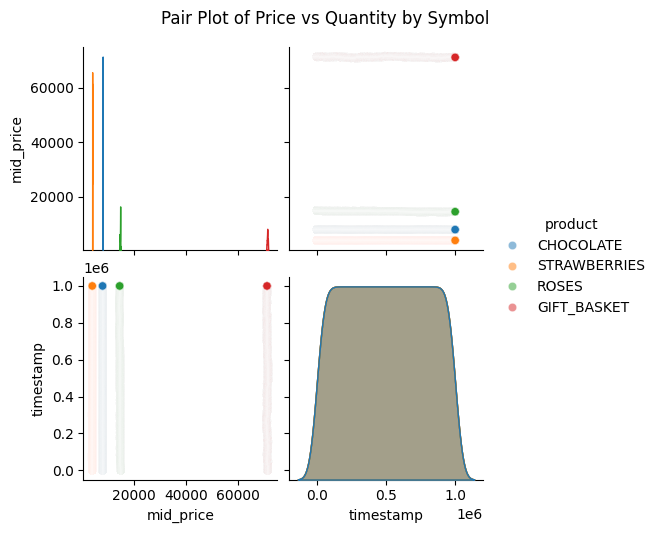

In [4]:
# Create a pair plot
pair_plot = sns.pairplot(
    df_day_0, vars=["mid_price", "timestamp"], hue="product", plot_kws={"alpha": 0.5}
)
pair_plot.fig.suptitle("Pair Plot of Price vs Quantity by Symbol", y=1.05)
plt.show()

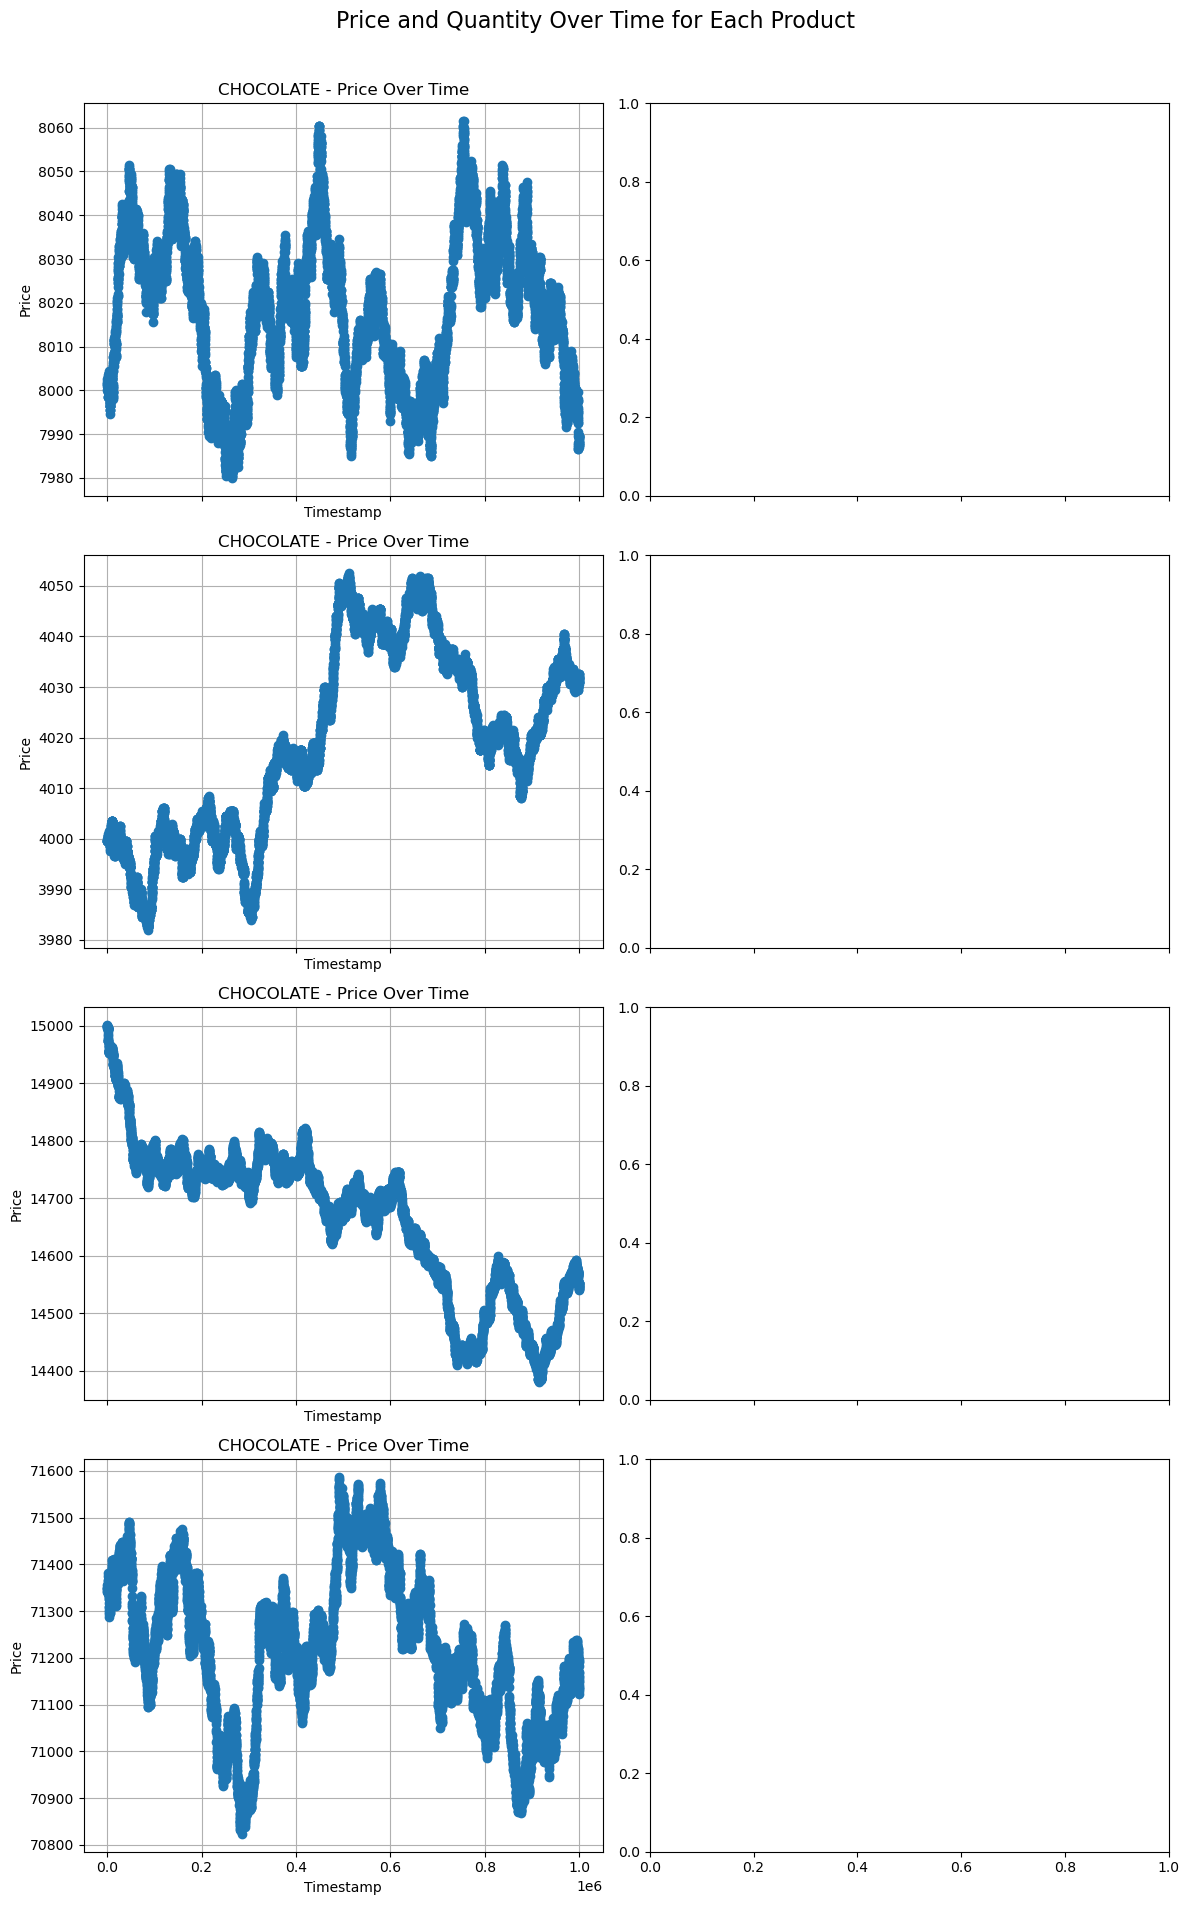

In [15]:
unique_symbols = df_day_0["product"].unique()
fig, axes = plt.subplots(
    nrows=len(unique_symbols),
    ncols=2,
    figsize=(12, 5 * len(unique_symbols)),
    sharex="col",
)
fig.suptitle("Price and Quantity Over Time for Each Product", fontsize=16)

for index, product in enumerate(unique_symbols):
    symbol_data = df_day_0[df_day_0["product"] == product]

    # Plotting price over time
    ax1 = axes[index, 0]
    ax1.plot(
        symbol_data["timestamp"], symbol_data["mid_price"], marker="o", linestyle="-"
    )
    ax1.set_title(f"{symbol} - Price Over Time")
    ax1.set_xlabel("Timestamp")
    ax1.set_ylabel("Price")
    ax1.grid(True)


plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

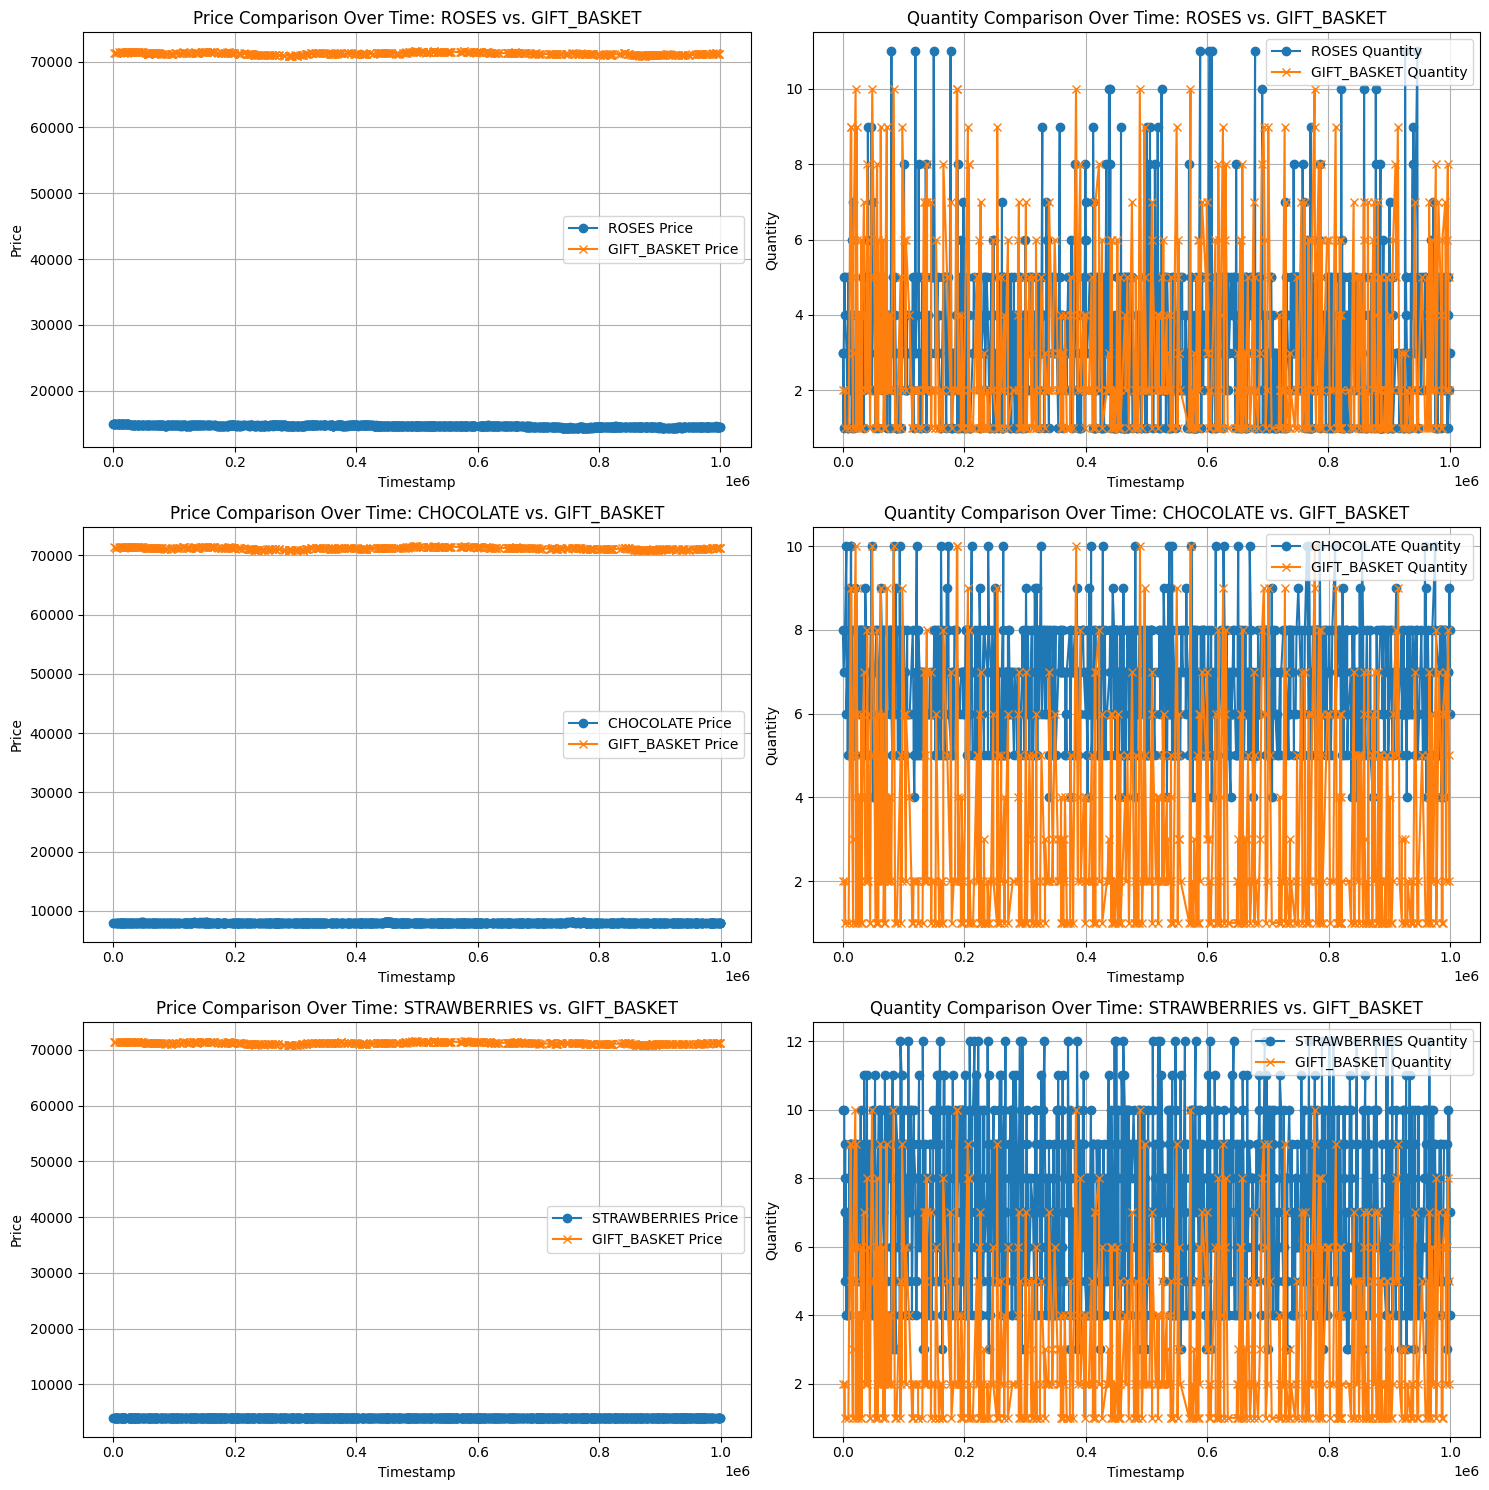

In [19]:
# Correcting variable name and selecting symbols to compare
symbols_to_compare = ["ROSES", "CHOCOLATE", "STRAWBERRIES"]
base_symbol = "GIFT_BASKET"
gift_basket_data = df_day_0[df_day_0["symbol"] == base_symbol]

# Creating plots
fig, axs = plt.subplots(
    len(symbols_to_compare), 2, figsize=(15, 5 * len(symbols_to_compare))
)

for index, symbol in enumerate(symbols_to_compare):
    symbol_data = df_day_0[df_day_0["symbol"] == symbol]

    # Price plot
    axs[index, 0].plot(
        symbol_data["timestamp"],
        symbol_data["price"],
        label=f"{symbol} Price",
        marker="o",
    )
    axs[index, 0].plot(
        gift_basket_data["timestamp"],
        gift_basket_data["price"],
        label=f"{base_symbol} Price",
        marker="x",
    )
    axs[index, 0].set_title(f"Price Comparison Over Time: {symbol} vs. {base_symbol}")
    axs[index, 0].set_xlabel("Timestamp")
    axs[index, 0].set_ylabel("Price")
    axs[index, 0].legend()
    axs[index, 0].grid(True)

    # Quantity plot
    axs[index, 1].plot(
        symbol_data["timestamp"],
        symbol_data["quantity"],
        label=f"{symbol} Quantity",
        marker="o",
    )
    axs[index, 1].plot(
        gift_basket_data["timestamp"],
        gift_basket_data["quantity"],
        label=f"{base_symbol} Quantity",
        marker="x",
    )
    axs[index, 1].set_title(
        f"Quantity Comparison Over Time: {symbol} vs. {base_symbol}"
    )
    axs[index, 1].set_xlabel("Timestamp")
    axs[index, 1].set_ylabel("Quantity")
    axs[index, 1].legend()
    axs[index, 1].grid(True)

plt.tight_layout()
plt.show()

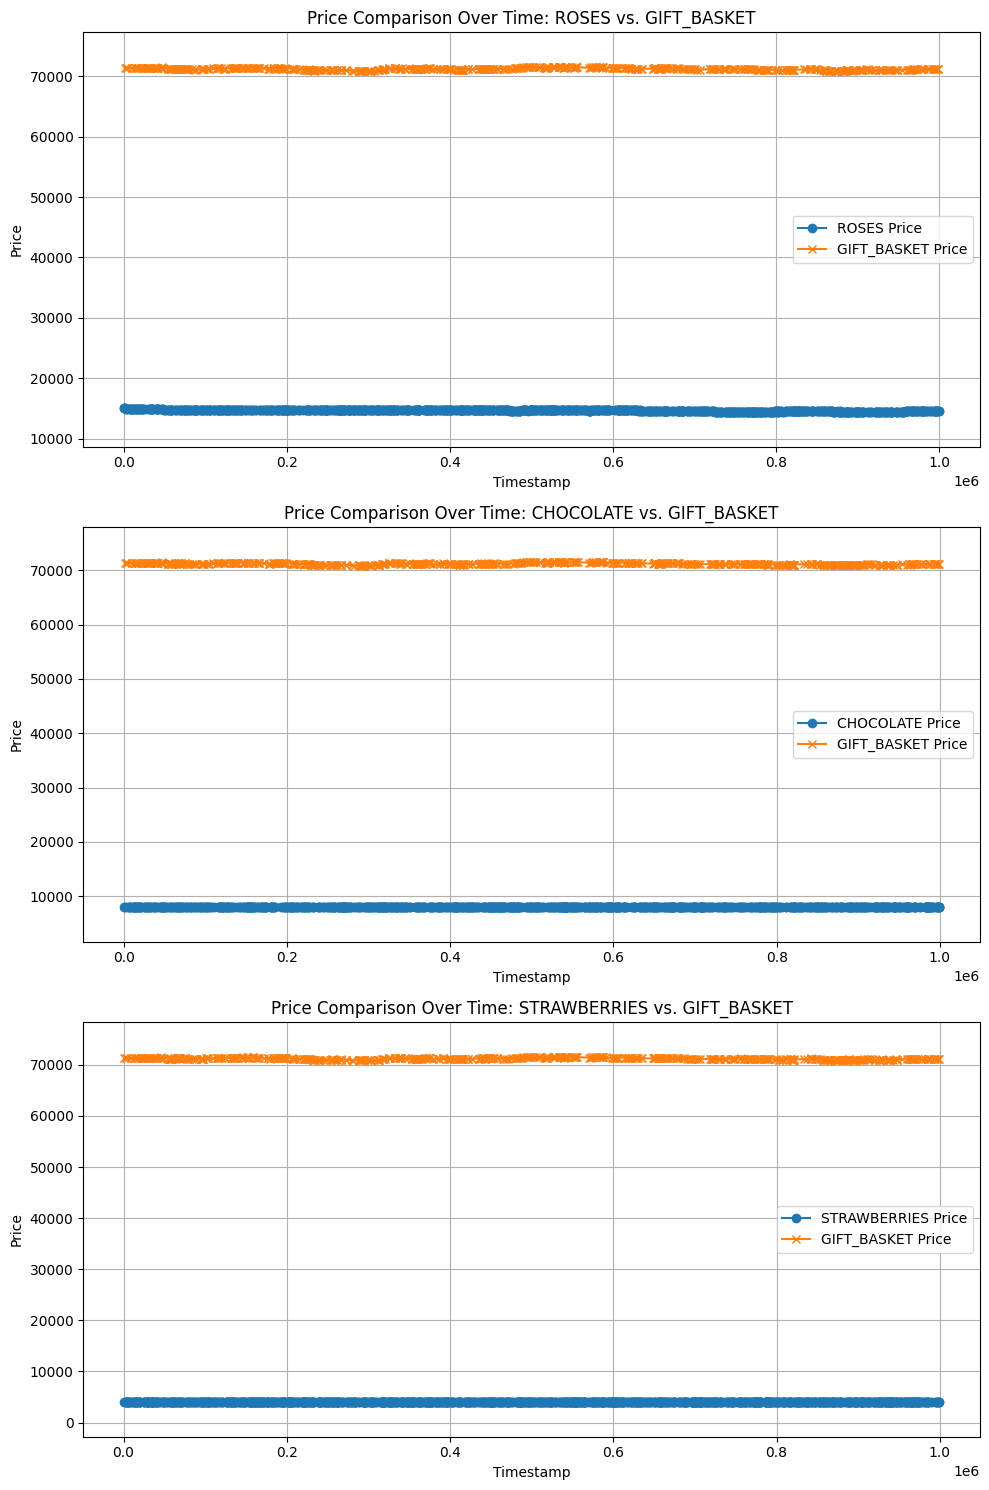

In [23]:
# Defining symbols to compare and the base symbol
symbols_to_compare = ["ROSES", "CHOCOLATE", "STRAWBERRIES"]
base_symbol = "GIFT_BASKET"
gift_basket_data = df_day_0[df_day_0["symbol"] == base_symbol]

# Creating a single plot for price comparison
fig, axs = plt.subplots(
    len(symbols_to_compare), 1, figsize=(10, 5 * len(symbols_to_compare))
)

for index, symbol in enumerate(symbols_to_compare):
    symbol_data = df_day_0[df_day_0["symbol"] == symbol]

    # Compute price limits for the y-axis
    min_price = min(symbol_data["price"].min(), gift_basket_data["price"].min())
    max_price = max(symbol_data["price"].max(), gift_basket_data["price"].max())
    price_pad = (max_price - min_price) * 0.1  # adding 10% padding

    # Price plot
    axs[index].plot(
        symbol_data["timestamp"],
        symbol_data["price"],
        label=f"{symbol} Price",
        marker="o",
    )
    axs[index].plot(
        gift_basket_data["timestamp"],
        gift_basket_data["price"],
        label=f"{base_symbol} Price",
        marker="x",
    )
    axs[index].set_title(f"Price Comparison Over Time: {symbol} vs. {base_symbol}")
    axs[index].set_xlabel("Timestamp")
    axs[index].set_ylabel("Price")
    axs[index].legend()
    axs[index].grid(True)
    axs[index].set_ylim(
        [min_price - price_pad, max_price + price_pad]
    )  # setting y-axis limits

plt.tight_layout()
plt.show()

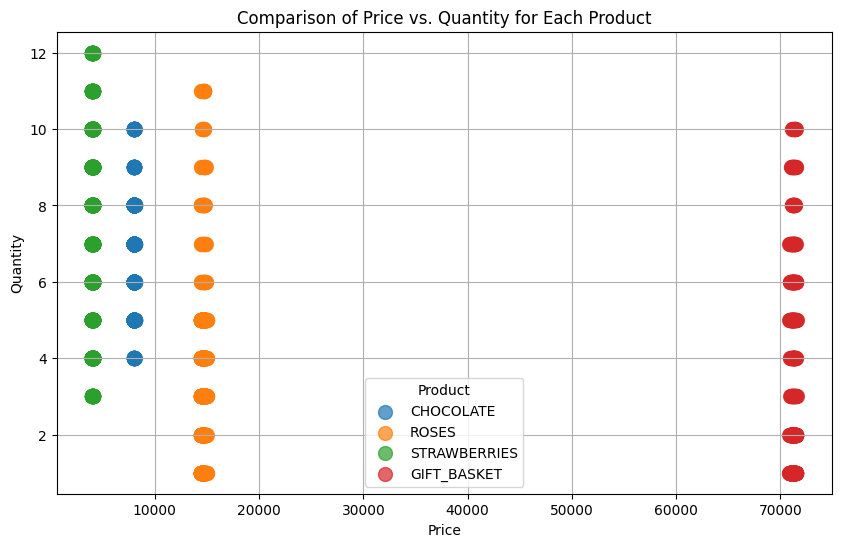

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
unique_symbols = df_day_0["symbol"].unique()

for symbol in unique_symbols:
    symbol_data = df_day_0[df_day_0["symbol"] == symbol]
    ax.scatter(
        symbol_data["price"], symbol_data["quantity"], label=symbol, s=100, alpha=0.7
    )

ax.set_title("Comparison of Price vs. Quantity for Each Product")
ax.set_xlabel("Price")
ax.set_ylabel("Quantity")
ax.legend(title="Product")
ax.grid(True)

plt.show()

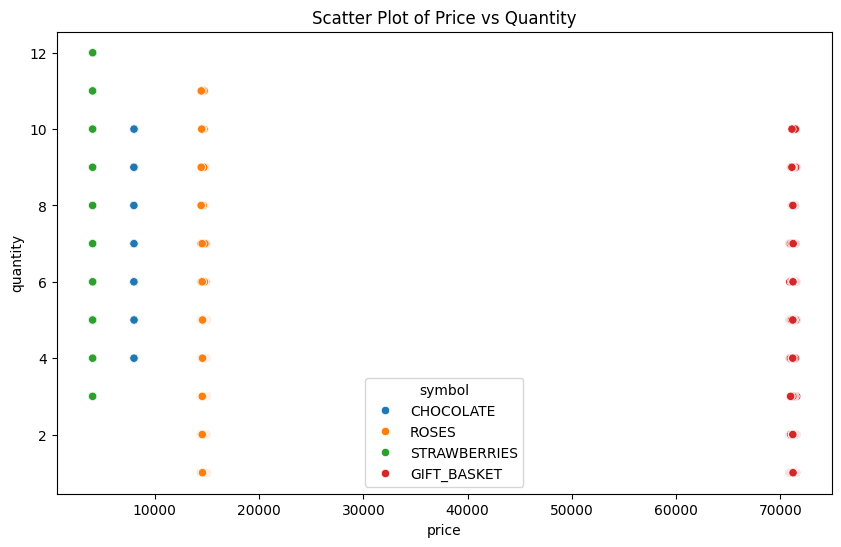

In [27]:
# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="price", y="quantity", hue="symbol", data=df_day_0)
plt.title("Scatter Plot of Price vs Quantity")
plt.show()

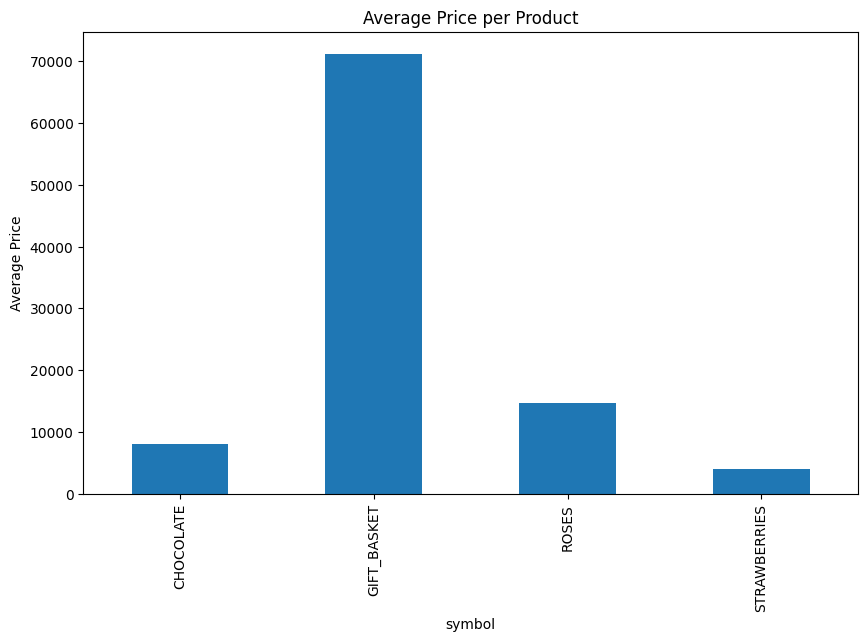

In [29]:
# Bar Chart
plt.figure(figsize=(10, 6))
df_day_0.groupby("symbol")["price"].mean().plot(kind="bar")
plt.title("Average Price per Product")
plt.ylabel("Average Price")
plt.show()

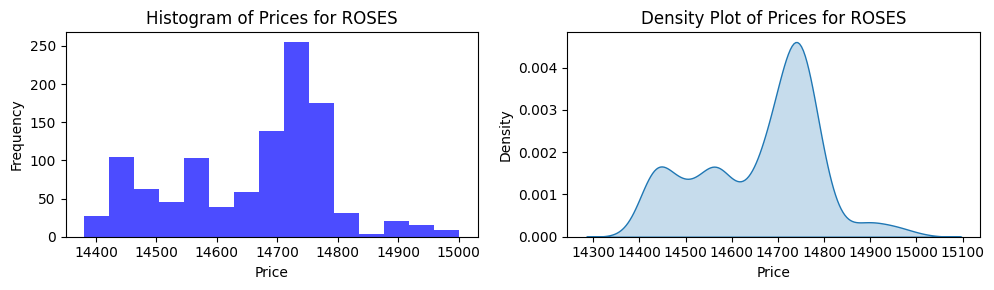

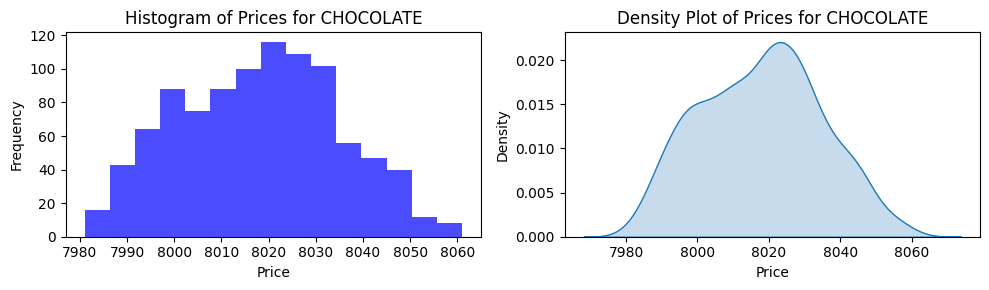

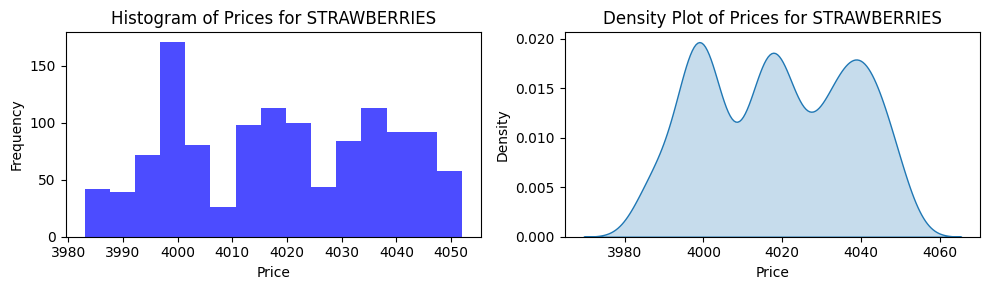

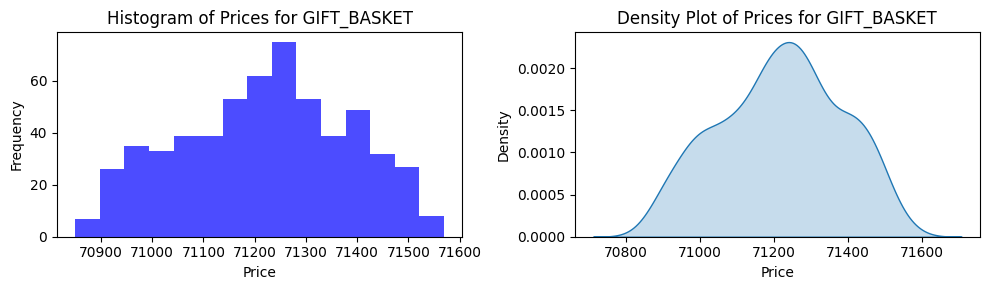

In [52]:
symbols_to_compare = ["ROSES", "CHOCOLATE", "STRAWBERRIES", "GIFT_BASKET"]

for symbol in symbols_to_compare:
    # Setup the figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    # Histogram
    axs[0].hist(
        df_day_0[df_day_0["symbol"] == symbol]["price"],
        bins=15,
        alpha=0.7,
        color="blue",
    )
    axs[0].set_title(f"Histogram of Prices for {symbol}")
    axs[0].set_xlabel("Price")
    axs[0].set_ylabel("Frequency")

    # Density Plot
    sns.kdeplot(df_day_0[df_day_0["symbol"] == symbol]["price"], ax=axs[1], fill=True)
    axs[1].set_title(f"Density Plot of Prices for {symbol}")
    axs[1].set_xlabel("Price")

    plt.tight_layout()
    plt.show()

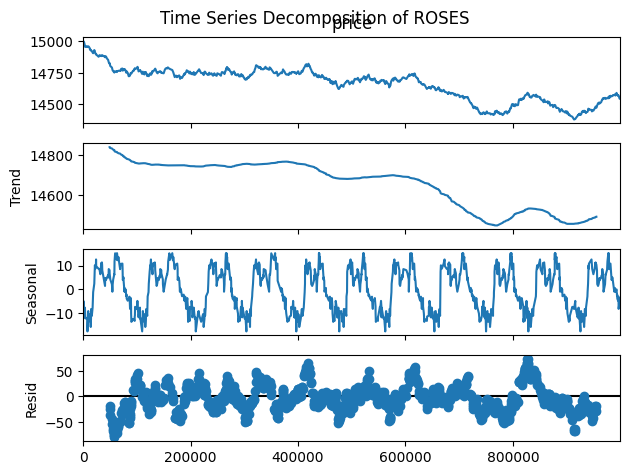

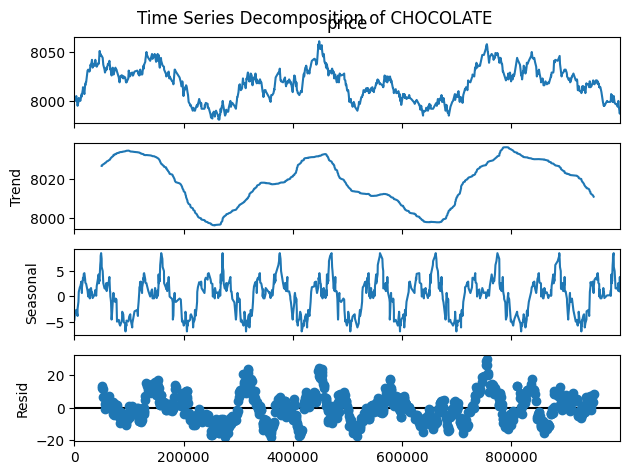

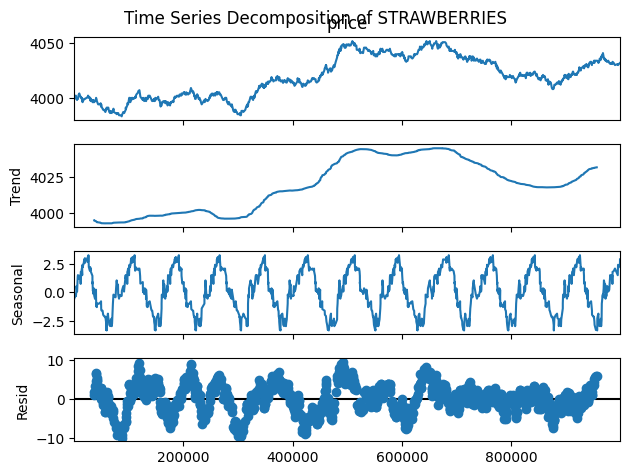

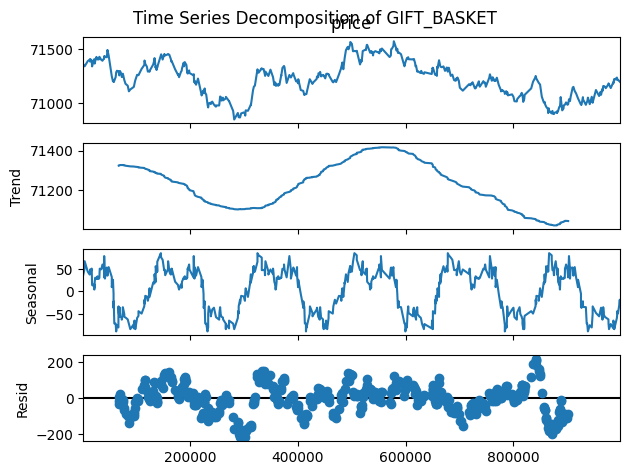

In [59]:
symbols_to_compare = ["ROSES", "CHOCOLATE", "STRAWBERRIES", "GIFT_BASKET"]

# Time Series Decomposition
for symbol in symbols_to_compare:
    series = df_day_0[df_day_0["symbol"] == symbol].set_index("timestamp")["price"]
    # Make sure there is more than one data point for decomposition
    if len(series) > 1:
        result = seasonal_decompose(series, model="additive", period=100)
        result.plot()
        plt.suptitle(
            f"Time Series Decomposition of {symbol}"
        )  # Using plt.suptitle to properly set the title
        plt.show()
    else:
        print(f"Not enough data for {symbol} to perform time series decomposition.")

Original: Shows the actual data.  
Trend: Shows the long-term movement in data, filtering out short-term fluctuations.  
Seasonal: Shows the repeating short-term pattern in the data.  
Resid (Residual): Shows the difference between the original series and the sum of the identified trend and seasonal components.


#### 1. Trend

A trend in a time series plot represents the long-term increase or decrease in the data. It shows a persistent, underlying movement in the data over time. This could be an upward, downward, or stable trend depending on how the data changes:

Upward Trend: The data points consistently increase over time.
Downward Trend: The data points consistently decrease over time.
Stable Trend: The data points do not show significant changes over time, staying relatively constant.

#### 2. Seasonality

Seasonality shows patterns that repeat over a known, fixed period. For example, ice cream sales might increase during summer months every year or retail sales spike during the holiday season. Seasonal effects are predictable and repeat in the same period every cycle, such as daily, monthly, or quarterly.

#### 3. Cyclic Changes

These are fluctuations that occur in the data that are not of a fixed period. These cycles can be caused by economic conditions like boom and bust cycles in an economy, which do not have a predictable pattern as seasonal effects do. They are often longer-term fluctuations compared to seasonal patterns.

#### 4. Irregular Component (Noise)

The irregular component consists of random fluctuations that do not form any pattern. These can be caused by unpredictable or random events and are usually impossible to predict in advance.

#### 5. Decomposition of Time Series

In the context of the Python seasonal_decompose method, the time series is broken down into three components: trend, seasonal, and residual. The residual component includes anything that is not explained by the trend and seasonal components and might include noise and cyclic variations if they are not part of the model used:

Trend Component: Extracted by smoothing or averaging the data over time.
Seasonal Component: Extracted by identifying and averaging the repeating short-term cycles in the data.
Residual Component: Obtained by removing the trend and seasonal components from the original data, showing what is left unexplained.


<Figure size 1000x600 with 0 Axes>

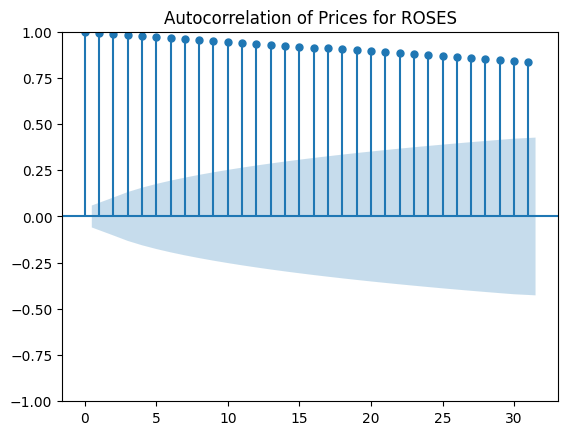

<Figure size 1000x600 with 0 Axes>

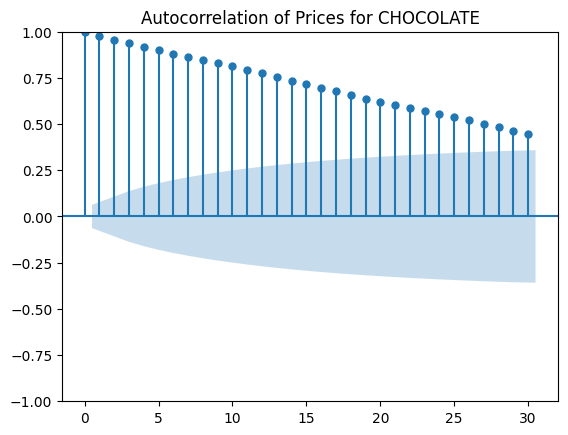

<Figure size 1000x600 with 0 Axes>

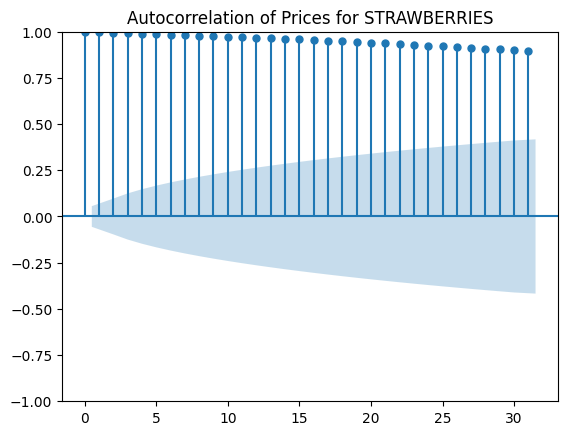

<Figure size 1000x600 with 0 Axes>

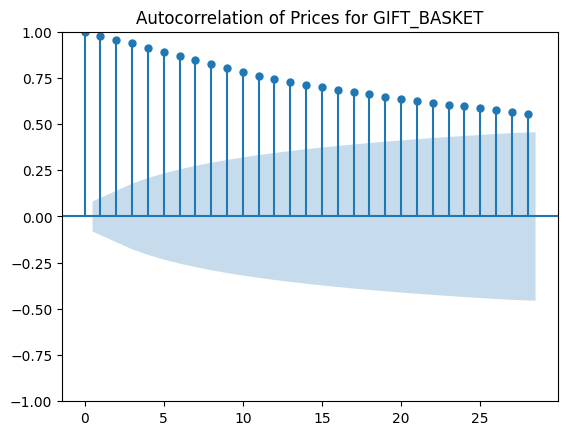

In [44]:
symbols_to_compare = ["ROSES", "CHOCOLATE", "STRAWBERRIES", "GIFT_BASKET"]

for symbol in symbols_to_compare:
    # Correlogram: Shows the autocorrelation function for the
    plt.figure(figsize=(10, 6))
    plot_acf(df_day_0[df_day_0["symbol"] == symbol]["price"])
    plt.title(f"Autocorrelation of Prices for {symbol}")
    plt.show()

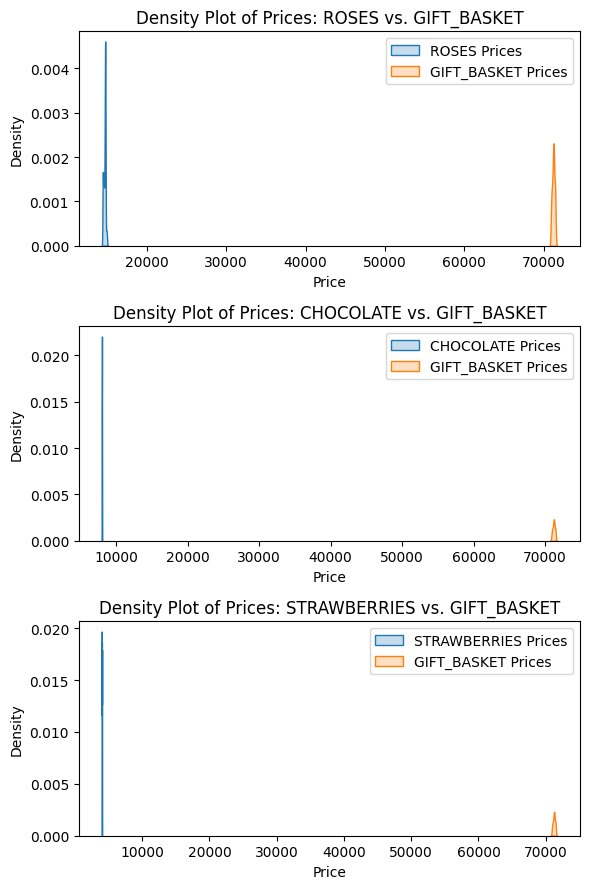

In [53]:
symbols_to_compare = ["ROSES", "CHOCOLATE", "STRAWBERRIES"]
base_symbol = "GIFT_BASKET"
gift_basket_data = df_day_0[df_day_0["symbol"] == base_symbol]

# Create a figure and axes with 1 column and a dynamic number of rows based on the symbol count
fig, axs = plt.subplots(
    nrows=len(symbols_to_compare), ncols=1, figsize=(6, 3 * len(symbols_to_compare))
)

# Ensure axs is always an array, even with one subplot
if len(symbols_to_compare) == 1:
    axs = [axs]

# Plot KDE for each symbol against GIFT_BASKET
for ax, symbol in zip(axs, symbols_to_compare):
    # Extract symbol data
    symbol_data = df_day_0[df_day_0["symbol"] == symbol]

    # Plot KDE for the symbol
    sns.kdeplot(symbol_data["price"], ax=ax, label=f"{symbol} Prices", fill=True)

    # Plot KDE for GIFT_BASKET
    sns.kdeplot(
        gift_basket_data["price"], ax=ax, label=f"{base_symbol} Prices", fill=True
    )

    ax.set_title(f"Density Plot of Prices: {symbol} vs. {base_symbol}")
    ax.set_xlabel("Price")
    ax.legend()

plt.tight_layout()
plt.show()

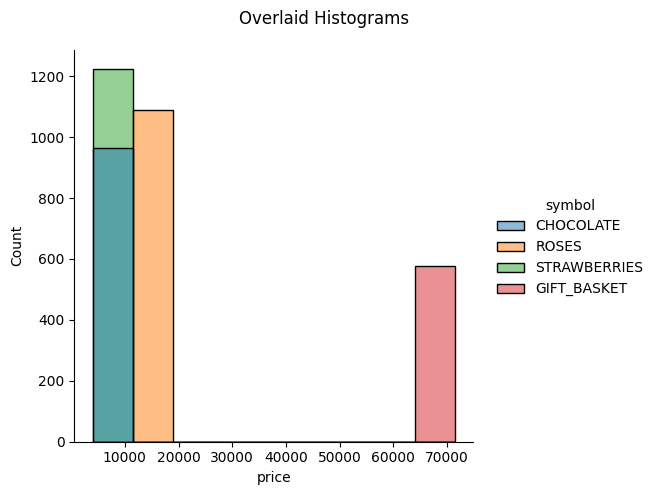

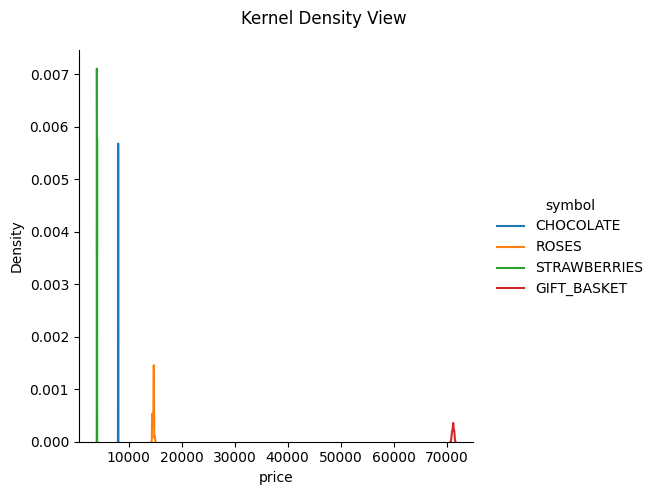

In [54]:
# Histograms with bins adjusted
g = sns.displot(df_day_0, x="price", hue="symbol", bins=9)
g.fig.suptitle("Overlaid Histograms")  # Use `fig.suptitle` for displot
g.fig.subplots_adjust(top=0.9)  # Adjust the title to not overlap with plots

# Kernel Density Estimate (KDE)
h = sns.displot(df_day_0, x="price", hue="symbol", kind="kde", bw_adjust=0.75)
h.fig.suptitle("Kernel Density View")
h.fig.subplots_adjust(top=0.9)

plt.show()

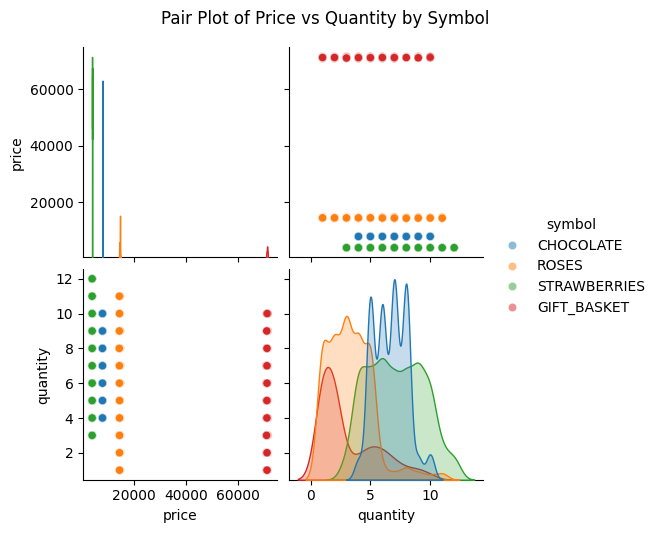

In [82]:
# Create a pair plot
pair_plot = sns.pairplot(
    df_day_0, vars=["price", "quantity"], hue="symbol", plot_kws={"alpha": 0.5}
)
pair_plot.fig.suptitle("Pair Plot of Price vs Quantity by Symbol", y=1.05)
plt.show()

## Modelling


In [64]:
# Creating new column for price * quantity
df_day_0["value"] = df_day_0["price"] * df_day_0["quantity"]
df_day_0

,timestamp,buyer,seller,symbol,currency,price,quantity,value
0,0,NaN,NaN,CHOCOLATE,SEASHELLS,8001.0,8,64008.0
1,0,NaN,NaN,ROSES,SEASHELLS,15001.0,3,45003.0
2,200,NaN,NaN,ROSES,SEASHELLS,15000.0,3,45000.0
3,500,NaN,NaN,STRAWBERRIES,SEASHELLS,3999.0,10,39990.0
4,1000,NaN,NaN,GIFT_BASKET,SEASHELLS,71360.0,2,142720.0
...,...,...,...,...,...,...,...,...
3850,999000,NaN,NaN,CHOCOLATE,SEASHELLS,7988.0,6,47928.0
3851,999200,NaN,NaN,STRAWBERRIES,SEASHELLS,4032.0,7,28224.0
3852,999200,NaN,NaN,CHOCOLATE,SEASHELLS,7989.0,8,63912.0
3853,999300,NaN,NaN,STRAWBERRIES,SEASHELLS,4032.0,4,16128.0


In [79]:
# Check if the pivot table operation is done correctly and resulting in data
pivot_df = df_day_0.pivot_table(
    index="timestamp",
    columns="symbol",
    values="value",
    aggfunc="mean",  # or 'sum', 'max' etc., based on your need
)
print(pivot_df.head())

symbol     CHOCOLATE  GIFT_BASKET    ROSES  STRAWBERRIES
timestamp                                               
0            64008.0          NaN  45003.0           NaN
200              NaN          NaN  45000.0           NaN
500              NaN          NaN      NaN       39990.0
1000             NaN     142720.0      NaN           NaN
1200             NaN          NaN  14997.0           NaN


In [77]:
# Dropping any rows with NaN values, which might happen if some symbols don't have data on some timestamps
pivot_df.dropna(inplace=True)

In [80]:
X = pivot_df.drop("GIFT_BASKET", axis=1)  # Drop target column from features
y = pivot_df["GIFT_BASKET"]  # Target column

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

# Creating a linear regression model
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Predicting the test set results
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Optionally, print R-squared to see the goodness of fit
r2 = model.score(X_test, y_test)
print(f"R-squared: {r2}")

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [73]:
print(pivot_df.shape)
print(pivot_df.head())

(0, 4)
Empty DataFrame
Columns: [CHOCOLATE, GIFT_BASKET, ROSES, STRAWBERRIES]
Index: []


symbol,CHOCOLATE,GIFT_BASKET,ROSES,STRAWBERRIES
timestamp,,,,


In [1]:
# Note I am reading in day 1
df_day_0 = pd.read_csv(file_path / "prices_round_3_day_1.csv", delimiter=";")  # day 0
df_day_0.head(10)

NameError: name 'pd' is not defined

In [157]:
# Note I am reading in day 1
df_day_0 = pd.read_csv(file_path / "prices_round_3_day_1.csv", delimiter=";")  # day 0
df_day_0.head(10)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,1,0,GIFT_BASKET,71108,12,71107.0,27.0,NaN,NaN,71121,12,71122.0,27.0,NaN,NaN,71114.5,0.0
1,1,0,CHOCOLATE,7987,104,NaN,NaN,NaN,NaN,7989,104,NaN,NaN,NaN,NaN,7988.0,0.0
2,1,0,ROSES,14545,27,14544.0,34.0,NaN,NaN,14546,61,NaN,NaN,NaN,NaN,14545.5,0.0
3,1,0,STRAWBERRIES,4030,237,NaN,NaN,NaN,NaN,4031,237,NaN,NaN,NaN,NaN,4030.5,0.0
4,1,100,STRAWBERRIES,4030,52,4029.0,137.0,NaN,NaN,4031,189,NaN,NaN,NaN,NaN,4030.5,0.0
5,1,100,ROSES,14543,20,14542.0,36.0,NaN,NaN,14544,56,NaN,NaN,NaN,NaN,14543.5,0.0
6,1,100,GIFT_BASKET,71109,1,71107.0,12.0,71106.0,20.0,71119,1,71121.0,12.0,71122.0,20.0,71114.0,0.0
7,1,100,CHOCOLATE,7987,100,NaN,NaN,NaN,NaN,7989,100,NaN,NaN,NaN,NaN,7988.0,0.0
8,1,200,ROSES,14543,26,14542.0,36.0,NaN,NaN,14544,62,NaN,NaN,NaN,NaN,14543.5,0.0
9,1,200,STRAWBERRIES,4029,198,NaN,NaN,NaN,NaN,4031,209,NaN,NaN,NaN,NaN,4030.0,0.0


In [158]:
df_day_0 = pd.pivot_table(
    df_day_0, index="timestamp", columns="product", values="mid_price"
)
df_day_0 = df_day_0.apply(pd.to_numeric)
# df_day_0.rename_axis(None, axis=1).reset_index(drop=True)

df_day_0

product,CHOCOLATE,GIFT_BASKET,ROSES,STRAWBERRIES
timestamp,,,,
0,7988.0,71114.5,14545.5,4030.5
100,7988.0,71114.0,14543.5,4030.5
200,7987.5,71115.5,14543.5,4030.0
300,7988.5,71123.5,14541.5,4030.0
400,7989.5,71132.5,14547.5,4030.0
...,...,...,...,...
999500,7883.0,70589.5,14421.0,4036.5
999600,7885.5,70599.5,14418.0,4036.5
999700,7885.5,70585.5,14421.5,4035.5


In [94]:
mod = AutoReg(df_day_0["GIFT_BASKET"].tolist(), 5, trend="n")
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                10000
Model:                     AutoReg(5)   Log Likelihood               -6000.863
Method:               Conditional MLE   S.D. of innovations              0.441
Date:                Tue, 16 Apr 2024   AIC                          12013.726
Time:                        21:17:25   BIC                          12056.985
Sample:                             5   HQIC                         12028.369
                                10000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.8511      0.010     85.099      0.000       0.832       0.871
y.L2           0.1290      0.013      9.822      0.000       0.103       0.155
y.L3           0.0412      0.013      3.123      0.0

In [95]:
mod = AutoReg(df_day_0["CHOCOLATE"].tolist(), 5, trend="n")
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                10000
Model:                     AutoReg(5)   Log Likelihood              -14595.129
Method:               Conditional MLE   S.D. of innovations              1.042
Date:                Tue, 16 Apr 2024   AIC                          29202.258
Time:                        21:18:42   BIC                          29245.517
Sample:                             5   HQIC                         29216.902
                                10000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.9884      0.010     98.833      0.000       0.969       1.008
y.L2           0.0073      0.014      0.516      0.606      -0.020       0.035
y.L3           0.0049      0.014      0.348      0.7

In [96]:
mod = AutoReg(df_day_0["ROSES"].tolist(), 5, trend="n")
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                10000
Model:                     AutoReg(5)   Log Likelihood              -24349.922
Method:               Conditional MLE   S.D. of innovations              2.766
Date:                Tue, 16 Apr 2024   AIC                          48711.843
Time:                        21:18:46   BIC                          48755.102
Sample:                             5   HQIC                         48726.486
                                10000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.9965      0.010     99.619      0.000       0.977       1.016
y.L2           0.0061      0.014      0.435      0.664      -0.022       0.034
y.L3           0.0179      0.014      1.266      0.2

In [97]:
mod = AutoReg(df_day_0["STRAWBERRIES"].tolist(), 5, trend="n")
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                10000
Model:                     AutoReg(5)   Log Likelihood               -6000.863
Method:               Conditional MLE   S.D. of innovations              0.441
Date:                Tue, 16 Apr 2024   AIC                          12013.726
Time:                        21:18:49   BIC                          12056.985
Sample:                             5   HQIC                         12028.369
                                10000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.8511      0.010     85.099      0.000       0.832       0.871
y.L2           0.1290      0.013      9.822      0.000       0.103       0.155
y.L3           0.0412      0.013      3.123      0.0

In [124]:
mod = VAR(df_day_0)
res = mod.fit(2)
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 16, Apr, 2024
Time:                     21:47:15
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    4.14671
Nobs:                     9998.00    HQIC:                   4.12954
Log likelihood:          -77309.8    FPE:                    61.6054
AIC:                      4.12075    Det(Omega_mle):         61.3840
--------------------------------------------------------------------
Results for equation CHOCOLATE
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  19.976899         7.860517            2.541           0.011
L1.CHOCOLATE            0.973806         0.011797           82.547           0.000
L1.GIFT_BASKET          0.003517         0.00168

C:\Users\Celes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [185]:
df_day_0["chocolate_q"] = 4
df_day_0["roses_q"] = 1
df_day_0["strawberries_q"] = 8
df_day_0["gift_basket_stated_price"] = (
    4 * df_day_0.CHOCOLATE + 1 * df_day_0.ROSES + 8 * df_day_0.STRAWBERRIES
)
df_day_0["gift_basket_estimated_price"] = (
    -14653
    + 4.6 * df_day_0.CHOCOLATE
    + 1.2 * df_day_0.ROSES
    + 7.8 * df_day_0.STRAWBERRIES
)
df_day_0["spread"] = df_day_0.GIFT_BASKET - df_day_0.gift_basket_estimated_price
df_day_0["gift_basket_varest"] = (
    4020
    + 0.18 * df_day_0.CHOCOLATE.shift(1)
    - 0.17 * df_day_0.CHOCOLATE.shift(2)
    + 0.05 * df_day_0.ROSES.shift(1)
    - 0.05 * df_day_0.ROSES.shift(2)
    + 0.15 * df_day_0.STRAWBERRIES.shift(1)
    - 0.11 * df_day_0.STRAWBERRIES.shift(2)
    + 0.97 * df_day_0.GIFT_BASKET.shift(1)
    - 0.03 * df_day_0.GIFT_BASKET.shift(2)
)
df_day_0["chocolate_varest"] = (
    19.8
    + 0.97 * df_day_0.CHOCOLATE.shift(1)
    + 0.024 * df_day_0.CHOCOLATE.shift(2)
    - 0.002 * df_day_0.ROSES.shift(1)
    + 0.002 * df_day_0.ROSES.shift(2)
    - 0.002 * df_day_0.STRAWBERRIES.shift(1)
    + 0.02 * df_day_0.STRAWBERRIES.shift(2)
    + 0.003 * df_day_0.GIFT_BASKET.shift(1)
    - 0.004 * df_day_0.GIFT_BASKET.shift(2)
)


df_day_0

product,CHOCOLATE,GIFT_BASKET,ROSES,STRAWBERRIES,chocolate_q,roses_q,strawberries_q,gift_basket_stated_price,gift_basket_estimated_price,spread,gift_basket_varest,chocolate_varest
timestamp,,,,,,,,,,,,
0,7988.0,71114.5,14545.5,4030.5,4,1,8,78741.5,70984.3,130.2,NaN,NaN
100,7988.0,71114.0,14543.5,4030.5,4,1,8,78739.5,70981.9,132.1,NaN,NaN
200,7987.5,71115.5,14543.5,4030.0,4,1,8,78733.5,70975.7,139.8,71108.145,7961.3090
300,7988.5,71123.5,14541.5,4030.0,4,1,8,78735.5,70977.9,145.6,71109.550,7960.8275
400,7989.5,71132.5,14547.5,4030.0,4,1,8,78745.5,70989.7,142.8,71117.485,7961.7975
...,...,...,...,...,...,...,...,...,...,...,...,...
999500,7883.0,70589.5,14421.0,4036.5,4,1,8,78245.0,70398.7,190.8,70614.595,7857.5805
999600,7885.5,70599.5,14418.0,4036.5,4,1,8,78252.0,70406.6,192.9,70614.260,7857.5915
999700,7885.5,70585.5,14421.5,4035.5,4,1,8,78247.5,70403.0,182.5,70624.420,7860.0305


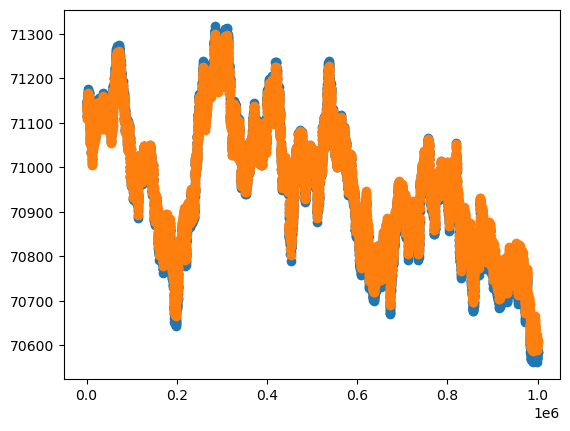

In [186]:
plt.plot(df_day_0.GIFT_BASKET.shift(1), label="Actual 1", marker="o", linewidth=0.25)
# plt.plot(df_day_0.gift_basket_estimated_price, label='Line 2', marker='s')
plt.plot(df_day_0.gift_basket_varest, label="Actual 1", marker="o", linewidth=0.25)

plt.show()

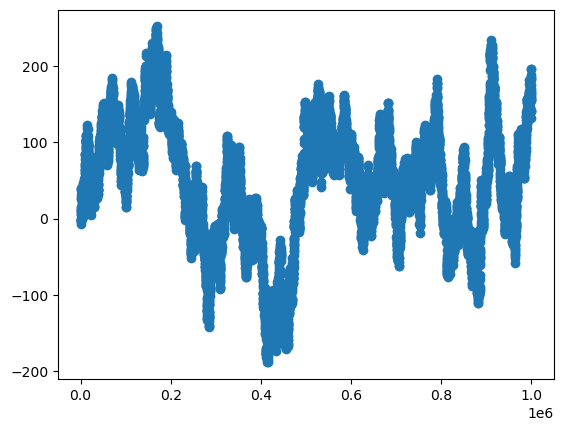

In [144]:
plt.plot(df_day_0.spread, label="Actual 1", marker="o")

plt.show()

In [149]:
df_day_0["spread"].mean()

45.71749000000494

In [152]:
df_day_0["spread"].std()
df_day_0["gift_basket_stated_price"].corr(df_day_0["GIFT_BASKET"])

0.8530106570445289

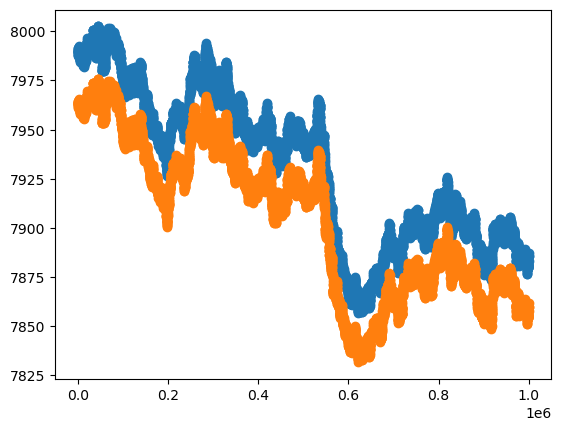

In [169]:
plt.plot(df_day_0.CHOCOLATE.shift(1), label="Actual 1", marker="o", linewidth=0.25)
# plt.plot(df_day_0.gift_basket_estimated_price, label='Line 2', marker='s')
plt.plot(df_day_0.chocolate_varest, label="Actual 1", marker="o", linewidth=0.25)

plt.show()